# Sales Forecasting Model

- The objectives of this Notebook is to analyze product sales data by sales territory and by week and predict sales for each product in each sales territory for the next 3 weeks (12 weeks)
- The steps followed are
  1. Exploratory Data Analysis to understand how sales could be related to time, filling missing values, filtering products and sales territories, cleaning dataset.
  2. Data preparation for the models, including filtering products with few data, resampling 
  3. Initial seasonal decomposition to identify if seasonality exists
  4. Stationarity check
  5. Differentiation
  6. SARIMA model fit
  7. SARIMA model evaluation
  8. SARIMA predictions visualization
  9. Analyzing seasonality for a selected product

## Importing libraries

In [55]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import STL
import warnings
import itertools
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Bigquery connection using Service Account key file

In [2]:
# Set up BigQuery client with service account
service_account_path = '../dbt/keys/prediction-model-python.json'
credentials = service_account.Credentials.from_service_account_file(service_account_path)
project_id = 'robotic-parsec-433018-g3'
client = bigquery.Client(credentials=credentials, project=project_id)

## Loading table with sales by week per product

In [3]:
def load_table(table_name):
    query = f"SELECT * FROM `{project_id}.dev_adventure_works.{table_name}`"
    return client.query(query).to_dataframe()

# Load all agg tables
agg_sales_by_product = load_table('agg_sales_by_product_ml')


In [4]:
agg_sales_by_product.head()

,product_id,product_name,product_category_name,product_subcategory_name,product_line,class,style,make_flag,safety_stock_level,reorder_point,...,unit_price_discount,avg_unit_freight,online_order_flag,ship_method_name,sales_person_id,sales_reason_names,sales_reason_types,discount_pct,is_first_purchase,has_discount
0,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,307.743200,False,CARGO TRANSPORT 5,2,None,None,0E-9,True,0
1,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,233.469100,False,CARGO TRANSPORT 5,5,None,None,0E-9,True,0
2,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,85.440575,False,CARGO TRANSPORT 5,8,None,None,0E-9,True,0
3,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,429.982100,False,CARGO TRANSPORT 5,10,None,None,0E-9,True,0
4,707,"Sport-100 Helmet, Red",Accessories,Helmets,S,None,None,False,4,3,...,0.0,291.589600,False,CARGO TRANSPORT 5,8,None,None,0E-9,True,0


In [5]:
agg_sales_by_product.columns

Index(['product_id', 'product_name', 'product_category_name',
       'product_subcategory_name', 'product_line', 'class', 'style',
       'make_flag', 'safety_stock_level', 'reorder_point',
       'days_to_manufacture', 'sell_start_date', 'sell_end_date',
       'finished_goods_flag', 'sales_territory_name', 'city_district_name',
       'state_province_name', 'store_name', 'store_id', 'week_start_date',
       'total_products_sold', 'unit_price', 'unit_price_discount',
       'avg_unit_freight', 'online_order_flag', 'ship_method_name',
       'sales_person_id', 'sales_reason_names', 'sales_reason_types',
       'discount_pct', 'is_first_purchase', 'has_discount'],
      dtype='object')

## Selecting data for the Time Series Forecasting

- The aggregations are per week, sales territory and product

In [6]:
time_series_df = agg_sales_by_product[[
                                        'week_start_date'
                                        , 'product_id'
                                        , 'sales_territory_name'
                                        , 'total_products_sold'
                                    ]].groupby([
                                        'week_start_date'
                                        , 'product_id'
                                        , 'sales_territory_name'
                                    ], as_index=False).agg({
                                        'total_products_sold': 'sum'
                                    })
time_series_df

,week_start_date,product_id,sales_territory_name,total_products_sold
0,2011-05-30,707,Canada,3
1,2011-05-30,707,Northeast,4
2,2011-05-30,707,Northwest,4
3,2011-05-30,707,Southeast,4
4,2011-05-30,707,Southwest,9
...,...,...,...,...
43416,2014-06-30,930,Northwest,1
43417,2014-06-30,931,Australia,3
43418,2014-06-30,931,Germany,2
43419,2014-06-30,932,Australia,1


## Selecting products to forecast data
- Since there are a lot of products and sales territory combinations, we will predict sales only for the top 5 most sold products.

In [7]:
# Calculate the total products sold for each product
product_sales = time_series_df.groupby('product_id')['total_products_sold'].sum().reset_index()

# Sort products by total products sold in descending order and get the top 5 products
top_5_products = product_sales.sort_values(by='total_products_sold', ascending=False).head(5)

# Filter the original dataset to include only the top 5 selling products
time_series_df = time_series_df[time_series_df['product_id'].isin(top_5_products['product_id'])]

# Display the filtered dataset
time_series_df


,week_start_date,product_id,sales_territory_name,total_products_sold
5,2011-05-30,708,Canada,8
6,2011-05-30,708,Central,1
7,2011-05-30,708,Northeast,2
8,2011-05-30,708,Northwest,2
9,2011-05-30,708,Southeast,5
...,...,...,...,...
43366,2014-06-30,715,Northwest,1
43367,2014-06-30,715,Southwest,1
43376,2014-06-30,870,Canada,1
43377,2014-06-30,870,Northwest,1


## Exploratory Data Analysis

### Missing values

In [8]:
# Check for missing values
print("Missing values per column:")
print(time_series_df.isnull().sum())

Missing values per column:
week_start_date         0
product_id              0
sales_territory_name    0
total_products_sold     0
dtype: int64


### Some statistical data

In [9]:
# Show descriptive statistics for the product quantity column
print(time_series_df['total_products_sold'].describe())

count       2714.0
mean     12.893515
std      13.633725
min            1.0
25%            4.0
50%            8.0
75%           17.0
max           98.0
Name: total_products_sold, dtype: Float64


### Converting date column into datetime

In [10]:
# Convert 'week_start_date' to datetime if not already done
time_series_df['week_start_date'] = pd.to_datetime(time_series_df['week_start_date'])

### Ploting general sales per week

In [11]:
# Aggregate total products sold by week to analyze overall sales trends
weekly_sales = time_series_df.groupby('week_start_date')['total_products_sold'].sum()

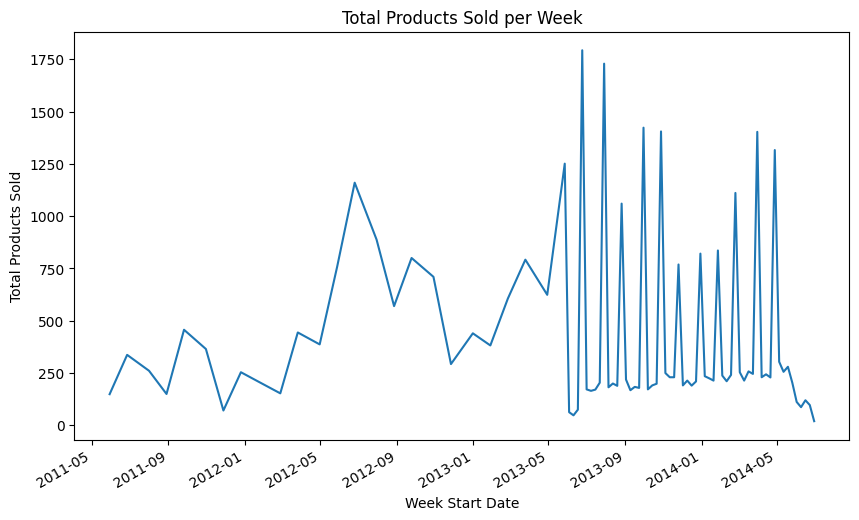

In [12]:
# Plot the total sales per week
plt.figure(figsize=(10, 6))
weekly_sales.plot(title='Total Products Sold per Week', xlabel='Week Start Date', ylabel='Total Products Sold')
plt.show()

### Number of unique sales territories and products

In [13]:
# Check how many unique products and sales territories are in the dataset
print("Number of unique products:", time_series_df['product_id'].nunique())
print("Number of unique sales territories:", time_series_df['sales_territory_name'].nunique())

Number of unique products: 5
Number of unique sales territories: 10


### Box plot of number of products sold

- The boxplot shows that the majority of sales are between 1 and 20 products per week. There are quite a few outliers above this range, with some instances reaching over 100 products sold in a week. This suggests that, while most weeks have low sales, there are occasional spikes.

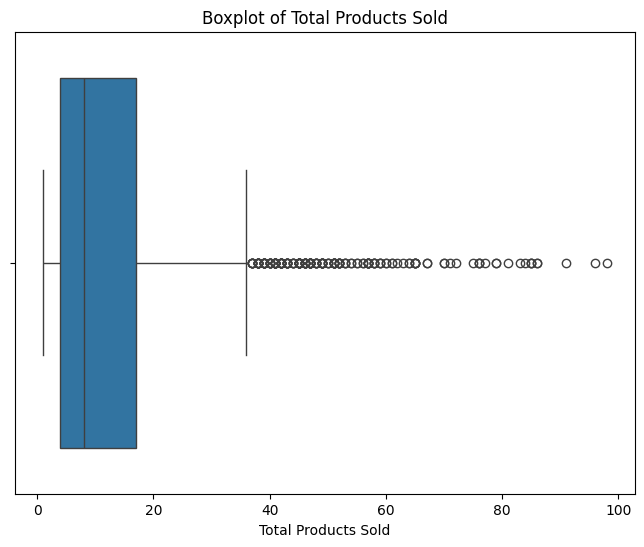

In [14]:
# Boxplot for total products sold
plt.figure(figsize=(8, 6))
sns.boxplot(x='total_products_sold', data=time_series_df)
plt.title('Boxplot of Total Products Sold')
plt.xlabel('Total Products Sold')
plt.show()


### Histogram of Total Products Sold
- The histogram indicates that the distribution of sales is highly skewed to the right, with most values concentrated between 1 and 20 products sold. A small number of weeks have higher sales, which are reflected in the outliers seen in the boxplot.

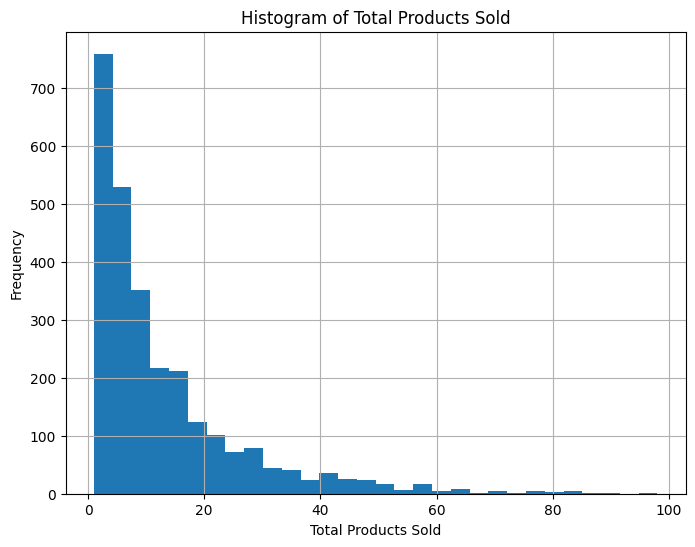

In [15]:
# Histogram for total products sold
plt.figure(figsize=(8, 6))
time_series_df['total_products_sold'].hist(bins=30)
plt.title('Histogram of Total Products Sold')
plt.xlabel('Total Products Sold')
plt.ylabel('Frequency')
plt.show()


###  Sales Over Time by Product
- The sales trends for various products show several peaks, particularly in 2013. Some products exhibit noticeable fluctuations, indicating that there may be seasonality or other external factors affecting sales.

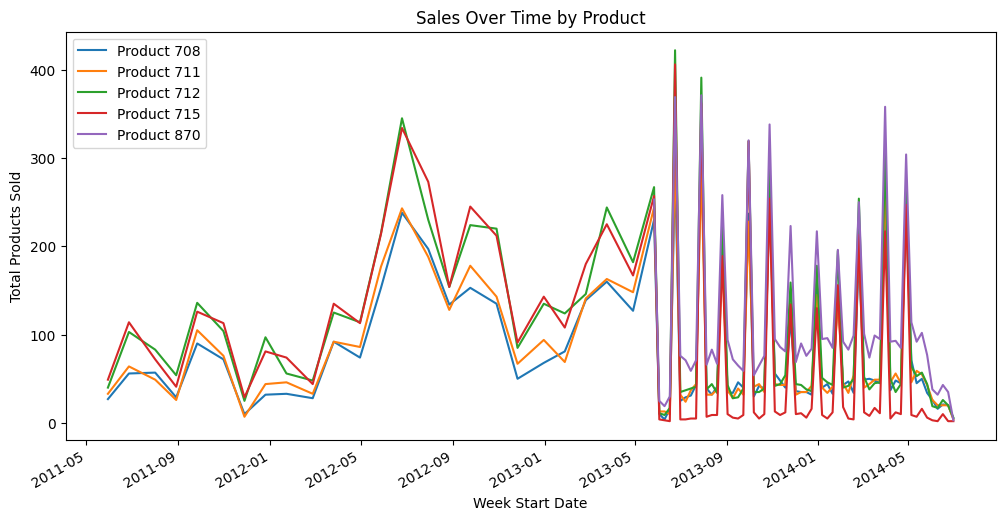

In [16]:
# Sales over time by product
plt.figure(figsize=(12, 6))
for product in time_series_df['product_id'].unique()[:5]:  # Limiting to first 5 products for clarity
    product_data = time_series_df[time_series_df['product_id'] == product]
    product_data.groupby('week_start_date')['total_products_sold'].sum().plot(label=f'Product {product}')
plt.title('Sales Over Time by Product')
plt.xlabel('Week Start Date')
plt.ylabel('Total Products Sold')
plt.legend()
plt.show()


### Sales Over Time by Sales Territory
- Similarly, the sales patterns by sales territory show fluctuations. Some sales territories seem to follow similar patterns, but the magnitude of sales varies. This could indicate that some sales territories are busier or more popular than others. The peaks around mid-2012 and 2013 appear across multiple sales territories.

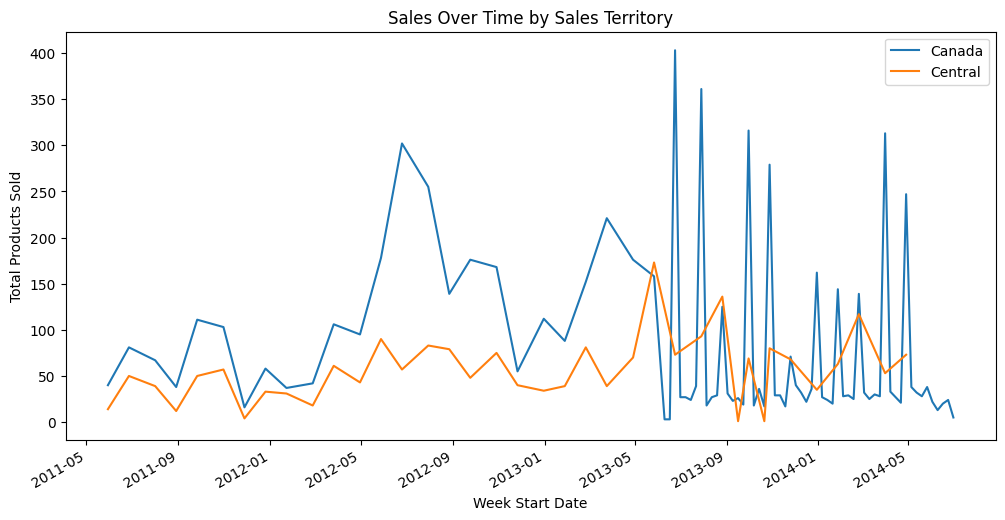

In [17]:
# Sales over time by sales territory
plt.figure(figsize=(12, 6))
for territory in time_series_df['sales_territory_name'].unique()[:2]:  # Limiting to first 2 territories for clarity
    territory_data = time_series_df[time_series_df['sales_territory_name'] == territory]
    territory_data.groupby('week_start_date')['total_products_sold'].sum().plot(label=f'{territory}')
plt.title('Sales Over Time by Sales Territory')
plt.xlabel('Week Start Date')
plt.ylabel('Total Products Sold')
plt.legend()
plt.show()


## Data Prep for Time Series

### Aggregating and Visualizing Weekly Sales Data

This function filters sales data for a specific product and sales territory, resamples it by week, and sums the total products sold. It then plots the weekly sales trend for the specified product and territory.



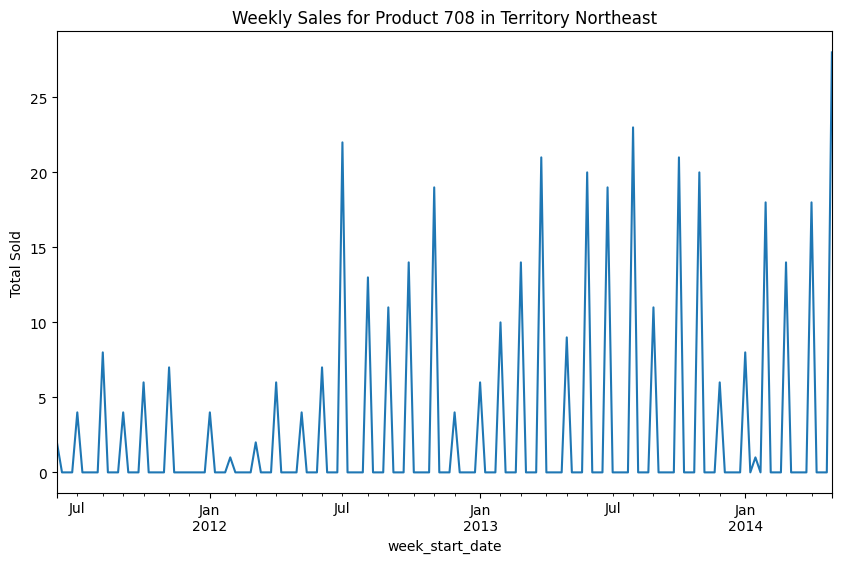

In [18]:
# Function to aggregate sales data by week for a product and sales territory
def prep_weekly_data(df, prod_id, territory_name):
    # Filter by product_id and sales_territory_name
    data = df.loc[(df['product_id'] == prod_id) & (df['sales_territory_name'] == territory_name)].copy()
    
    # Convert 'week_start_date' to datetime (if not already)
    data['week_start_date'] = pd.to_datetime(data['week_start_date'])
    
    # Set 'week_start_date' as the index
    data.set_index('week_start_date', inplace=True)
    
    # Resample to weekly frequency (start of the week) and sum total products sold per week
    weekly_data = data['total_products_sold'].resample('W').sum()
    
    return weekly_data

# Example: Apply the function for a specific product and the 'Northeast' territory
prod_id = 708
territory_name = "Northeast"
weekly_data = prep_weekly_data(time_series_df, prod_id, territory_name)

# Plot the weekly sales data
weekly_data.plot(title=f'Weekly Sales for Product {prod_id} in Territory {territory_name}', figsize=(10, 6))
plt.ylabel('Total Sold')
plt.show()


- Here, we aggregate by week the sales per product in each territory

In [19]:
# Create an empty DataFrame to store the results
weekly_sales_df = pd.DataFrame()

# Loop through each unique product and territory
for product_id in time_series_df['product_id'].unique():
    for territory_name in time_series_df['sales_territory_name'].unique():
        
        # Prepare weekly data for the product and territory
        weekly_data = prep_weekly_data(time_series_df, product_id, territory_name)
        
        # Create a temporary DataFrame to store this product and territory's data
        temp_df = pd.DataFrame({
            'product_id': product_id,
            'sales_territory_name': territory_name,
            'week_start_date': weekly_data.index,
            'total_products_sold': weekly_data.values
        })
        
        # Append the result to the main DataFrame
        weekly_sales_df = pd.concat([weekly_sales_df, temp_df], ignore_index=True)

# Check the structure of the resulting DataFrame
weekly_sales_df.head()

,product_id,sales_territory_name,week_start_date,total_products_sold
0,708,Canada,2011-06-05,8
1,708,Canada,2011-06-12,0
2,708,Canada,2011-06-19,0
3,708,Canada,2011-06-26,0
4,708,Canada,2011-07-03,15


### Filtering products with less than 2 years of data
- This is done because we need at least 104 weeks of data to have a reliable prediction

In [20]:
# Group by product_id and sales_territory_name, then count the unique week_start_date values (number of weeks)
grouped_df = weekly_sales_df.groupby(['product_id', 'sales_territory_name']).agg(weeks=('week_start_date', 'nunique')).reset_index()

# Filter to keep only the groups with more than 104 weeks
filtered_groups = grouped_df[grouped_df['weeks'] > 104]

# Merge the filtered groups back with the original DataFrame to keep only the relevant rows
weekly_sales_df_filtered = weekly_sales_df.merge(filtered_groups[['product_id', 'sales_territory_name']], on=['product_id', 'sales_territory_name'], how='inner')

# Overwrite the original DataFrame with the filtered one (if desired)
weekly_sales_df = weekly_sales_df_filtered

# Check the final result
weekly_sales_df


,product_id,sales_territory_name,week_start_date,total_products_sold
0,708,Canada,2011-06-05,8
1,708,Canada,2011-06-12,0
2,708,Canada,2011-06-19,0
3,708,Canada,2011-06-26,0
4,708,Canada,2011-07-03,15
...,...,...,...,...
4654,715,United Kingdom,2014-05-25,2
4655,715,United Kingdom,2014-06-01,1
4656,715,United Kingdom,2014-06-08,1
4657,715,United Kingdom,2014-06-15,1


### Filling missing weeks data
- To perform ARIMA, dates should be continuous

In [21]:
def fill_missing_weeks(df):
    # Define a function to fill missing weeks for a product-territory combination
    def fill_group(group):
        group = group.sort_values(by='week_start_date')

        # Create a complete date range (weekly, starting on Sundays)
        all_weeks = pd.date_range(start=group['week_start_date'].min(),
                                  end=group['week_start_date'].max(),
                                  freq='W-SUN')

        # Reindex with the complete date range and fill missing sales with 0
        group = group.set_index('week_start_date').reindex(all_weeks, fill_value=0).reset_index()

        # Add back the product_id and sales_territory_name to the filled DataFrame
        group['product_id'] = group['product_id'].iloc[0]
        group['sales_territory_name'] = group['sales_territory_name'].iloc[0]

        # Rename columns for consistency
        group.rename(columns={'index': 'week_start_date'}, inplace=True)

        return group

    # Apply the fill_group function to each product-territory group and concatenate the results
    return pd.concat([fill_group(group) for _, group in df.groupby(['product_id', 'sales_territory_name'])], ignore_index=True)

# Apply the function to fill missing weeks for `weekly_sales_df`
weekly_sales_df = fill_missing_weeks(weekly_sales_df)

# Display the resulting DataFrame
weekly_sales_df


,week_start_date,product_id,sales_territory_name,total_products_sold
0,2011-06-05,708,Canada,8
1,2011-06-12,708,Canada,0
2,2011-06-19,708,Canada,0
3,2011-06-26,708,Canada,0
4,2011-07-03,708,Canada,15
...,...,...,...,...
4654,2014-05-25,715,United Kingdom,2
4655,2014-06-01,715,United Kingdom,1
4656,2014-06-08,715,United Kingdom,1
4657,2014-06-15,715,United Kingdom,1


## Seasonal Decomposition of Time Series

- Purpose: Decompose sales data into **trend**, **seasonality**, and **residuals** for each product and territory to uncover hidden patterns.

- Functionality
  - **Automated Decomposition**: Loops through all product-territory pairs.
  - **STL Decomposition**: Separates data into:
    - **Trend**: Long-term movement.
    - **Seasonality**: Repeating short-term patterns.
    - **Residuals**: Irregular fluctuations.

- Reason: Understand the sales behavior by isolating trends and seasonal effects, aiding decision-making for forecasting and business strategy.


In [22]:
# Function to decompose the time series
def decompose_series(time_series, seasonal=13):
    stl = STL(time_series, seasonal=seasonal)
    result = stl.fit()
    return result

# Function to apply decomposition to all products
def decompose_all_products(df):
    decomposition_results = {}

    for product_id in df['product_id'].unique():
        for territory_name in df['sales_territory_name'].unique():
            filtered_data = df[(df['product_id'] == product_id) & 
                               (df['sales_territory_name'] == territory_name)]
            time_series = filtered_data.set_index('week_start_date')['total_products_sold']
            
            # Ensure there is enough data for seasonal decomposition
            if len(time_series) > 2 * 13:
                result = decompose_series(time_series)
                
                decomposition_results[(product_id, territory_name)] = {
                    'trend': result.trend,
                    'seasonal': result.seasonal,
                    'resid': result.resid
                }
    
    return decomposition_results


### Ploting example 
- As seen below, SARIMA would be a great model choice, once it considers seasonality, which is clearly present on the data as seen below.

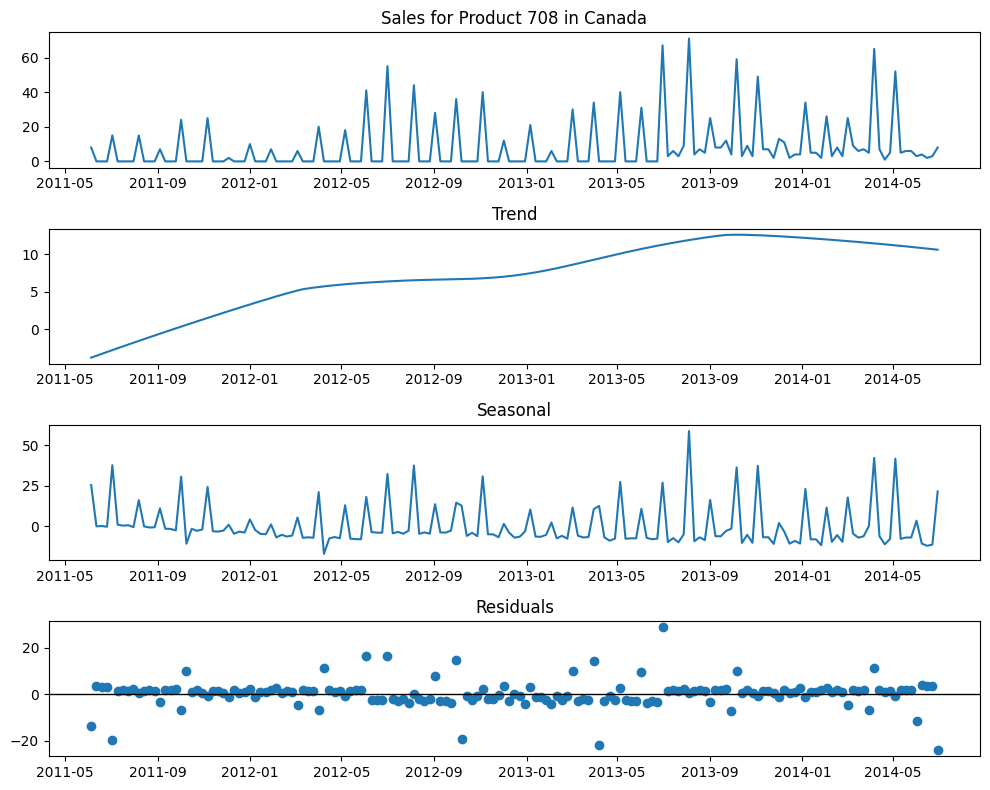

In [23]:
# Function to decompose the time series
def decompose_series(time_series, seasonal=51):
    stl = STL(time_series, seasonal=seasonal)
    result = stl.fit()
    return result

# Function to apply decomposition to all products
def decompose_all_products(df, seasonal=51):
    decomposition_results = {}

    for product_id in df['product_id'].unique():
        for territory_name in df['sales_territory_name'].unique():
            filtered_data = df[(df['product_id'] == product_id) & 
                               (df['sales_territory_name'] == territory_name)]
            time_series = filtered_data.set_index('week_start_date')['total_products_sold']
            
            if len(time_series) > 2 * seasonal:  # Ensure there is enough data for decomposition
                result = decompose_series(time_series, seasonal=seasonal)
                
                decomposition_results[(product_id, territory_name)] = {
                    'trend': result.trend,
                    'seasonal': result.seasonal,
                    'resid': result.resid
                }
    
    return decomposition_results

# Decompose all products
decomposition_results = decompose_all_products(weekly_sales_df)

# Example: Plot decomposition for one product and territory
product_id_example = 708
territory_example = 'Canada'

# Retrieve and plot the results for the chosen product and territory
example_result = decomposition_results[(product_id_example, territory_example)]

# Plot the sales, trend, seasonal, and residual components
plt.figure(figsize=(10, 8))

# Sales plot (first plot)
plt.subplot(411)
plt.plot(weekly_sales_df[(weekly_sales_df['product_id'] == product_id_example) & 
                         (weekly_sales_df['sales_territory_name'] == territory_example)]
         .set_index('week_start_date')['total_products_sold'])
plt.title(f"Sales for Product {product_id_example} in {territory_example}")

# Trend plot (second plot)
plt.subplot(412)
plt.plot(example_result['trend'])
plt.title("Trend")

# Seasonal plot (third plot)
plt.subplot(413)
plt.plot(example_result['seasonal'])
plt.title("Seasonal")

# Residuals plot (fourth plot)
plt.subplot(414)
plt.scatter(example_result['resid'].index, example_result['resid'])
plt.axhline(y=0, color='black', linewidth=1)
plt.title("Residuals")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Save decomposition results for further analysis
decomposition_df = pd.DataFrame.from_dict(decomposition_results, orient='index')


## Checking for stationarity
- To use ARIMA, data should be stationary
- We check here using ADF test for stationarity

In [24]:
def perform_adf_test(weekly_sales_df):
    # Initialize empty list for results
    adf_results = []

    # Loop through product_id and sales_territory_name combinations
    for (product_id, territory), group in weekly_sales_df.groupby(['product_id', 'sales_territory_name']):
        
        # Sort by week_start_date
        group = group.sort_values(by='week_start_date')
        
        # Get the total_products_sold series
        demand_series = group['total_products_sold']
        
        # Perform ADF test if there are enough data points
        if len(demand_series) > 1:
            adf_test = adfuller(demand_series)
            adf_statistic = adf_test[0]
            p_value = adf_test[1]
            critical_values = adf_test[4]

            # Append results for this product-territory combination
            adf_results.append({
                'product_id': product_id,
                'sales_territory_name': territory,
                'ADF Statistic': adf_statistic,
                'p-value': p_value,
                'Critical Values': critical_values,
                'Stationary': 'Yes' if p_value < 0.05 else 'No'
            })

    # Convert the results list to a DataFrame
    adf_results_df = pd.DataFrame(adf_results)
    
    return adf_results_df

adf_results_df = perform_adf_test(weekly_sales_df)
adf_results_df

,product_id,sales_territory_name,ADF Statistic,p-value,Critical Values,Stationary
0,708,Canada,-1.714469,0.423673,"{'1%': -3.4753253063120644, '5%': -2.881274703...",No
1,708,Central,-1.717906,0.421911,"{'1%': -3.4782936965183815, '5%': -2.882567574...",No
2,708,France,-1.458695,0.553837,"{'1%': -3.5011373281819504, '5%': -2.892480052...",No
3,708,Northeast,-1.251841,0.650907,"{'1%': -3.4779446621720114, '5%': -2.882415612...",No
4,708,Northwest,-1.906275,0.329115,"{'1%': -3.4750180242954167, '5%': -2.881140802...",No
5,708,Southeast,-1.507920,0.529590,"{'1%': -3.4750180242954167, '5%': -2.881140802...",No
6,708,Southwest,-1.761481,0.399746,"{'1%': -3.4750180242954167, '5%': -2.881140802...",No
7,708,United Kingdom,-1.521802,0.522700,"{'1%': -3.4968181663902103, '5%': -2.890610751...",No
8,711,Canada,-2.405067,0.140311,"{'1%': -3.4750180242954167, '5%': -2.881140802...",No
9,711,Central,-1.923496,0.321090,"{'1%': -3.4779446621720114, '5%': -2.882415612...",No


## Differentiating series
- For non-stationary series, we should apply differentiation to try to make it stationary

In [25]:
# Differencing non-stationary series
def difference_non_stationary_series(weekly_sales_df, adf_results_df):
    non_stationary_combinations = adf_results_df[adf_results_df['Stationary'] == 'No'][['product_id', 'sales_territory_name']]
    
    # Apply differencing only to non-stationary series
    weekly_sales_df['differenced_sales'] = weekly_sales_df.groupby(['product_id', 'sales_territory_name'])['total_products_sold'].transform(
        lambda x: x.diff() if (x.name[0], x.name[1]) in non_stationary_combinations.values else x
    )
    
    return weekly_sales_df
weekly_sales_df_diff = difference_non_stationary_series(weekly_sales_df, adf_results_df)

weekly_sales_df_diff

,week_start_date,product_id,sales_territory_name,total_products_sold,differenced_sales
0,2011-06-05,708,Canada,8,<NA>
1,2011-06-12,708,Canada,0,-8
2,2011-06-19,708,Canada,0,0
3,2011-06-26,708,Canada,0,0
4,2011-07-03,708,Canada,15,15
...,...,...,...,...,...
4654,2014-05-25,715,United Kingdom,2,1
4655,2014-06-01,715,United Kingdom,1,-1
4656,2014-06-08,715,United Kingdom,1,0
4657,2014-06-15,715,United Kingdom,1,0


## SARIMA model training
- After selecting the parameters, now we should perform the model training per product-territory combination

In [27]:
# Function to train SARIMA models using auto_arima with limited search space and forecast the next 13 weeks
def forecast_sarima_auto_arima(df, forecast_periods=13):
    forecast_results = []
    
    # Loop over each product-territory combination
    for (prod_id, terr), group in df.groupby(['product_id', 'sales_territory_name']):
        group = group.dropna(subset=['differenced_sales'])  # Clean data
        
        if len(group) > forecast_periods:
            try:
                # Limit the search space of auto_arima
                model_auto = auto_arima(group['differenced_sales'],
                                        seasonal=True,
                                        m=52,  # Weekly seasonal cycle
                                        max_p=3,  # Limit the AR order
                                        max_d=2,  # Limit the differencing order
                                        max_q=3,  # Limit the MA order
                                        max_P=2,  # Limit the seasonal AR order
                                        max_D=1,  # Limit the seasonal differencing order
                                        max_Q=2,  # Limit the seasonal MA order
                                        trace=True,  # Disable verbose output
                                        error_action='ignore',  
                                        suppress_warnings=True)
                
                # Training the SARIMA model with the best parameters found by auto_arima
                order = model_auto.order
                seasonal_order = model_auto.seasonal_order
                model = SARIMAX(group['differenced_sales'], 
                                order=order, 
                                seasonal_order=seasonal_order)
                
                model_fit = model.fit(disp=False)
                
                # Forecast for the next 'forecast_periods' weeks
                forecast = model_fit.forecast(steps=forecast_periods)
                
                # Store the forecast results
                forecast_results.append({
                    'product_id': prod_id,
                    'sales_territory_name': terr,
                    'forecast': forecast.values
                })
                
            except Exception as e:
                print(f"Error for product {prod_id} in territory {terr}: {e}")
    
    return pd.DataFrame(forecast_results)

# Perform forecasting using auto_arima for each product-territory combination
sarima_forecasts = forecast_sarima_auto_arima(weekly_sales_df_diff)

# Display the forecast results
sarima_forecasts


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=11.10 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1451.688, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=3.93 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1449.688, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=1409.846, Time=1.31 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=1406.898, Time=7.21 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=20.12 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=1348.811, Time=10.49 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=34.17 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=13.69 sec
 ARIMA(1,0,1)(2,0,0)[52] intercept   : AIC=inf, Time=21.83 sec
 ARIMA(0,0,1)(2,0,0)[52] intercept   : AIC=inf, Time=18.99

,product_id,sales_territory_name,forecast
0,708,Canada,"[3.014522089827314, -3.716214385241217, -2.702..."
1,708,Central,"[-12.275815378002173, 3.611101848524559e-15, -..."
2,708,Northeast,"[-34.968033141858214, 7.094749722163906, 0.281..."
3,708,Northwest,"[6.887796059681132, 2.518374461649063, -2.1344..."
4,708,Southeast,"[1.80694260233148, -3.5352012950426674, -1.713..."
5,708,Southwest,"[5.560486289051349, -0.9374107276767494, -4.04..."
6,708,United Kingdom,"[1.6256394908578082, -0.3082321195065456, -0.5..."
7,711,Canada,"[6.362590914202918, -2.2684743067387663, -2.41..."
8,711,Central,"[-13.643983869442627, -0.7266190896145652, 2.8..."
9,711,France,"[2.1557169903035804, -0.13646384028967717, -0...."


In [67]:
sarima_forecasts.to_csv('demand-forecast.csv')

### Reversing differentiation 

In [31]:
def inverse_difference(original, forecast, interval=1):
    inverted_forecast = []
    # Start with the last value of the original series to reconstruct the forecast
    last_value = original.iloc[-interval]
    for diff_value in forecast:
        inverted_value = diff_value + last_value
        inverted_forecast.append(inverted_value)
        last_value = inverted_value
    return inverted_forecast

# Apply inverse differencing to your forecasts
sarima_forecasts['original_forecast'] = sarima_forecasts.apply(
    lambda row: inverse_difference(weekly_sales_df_diff[weekly_sales_df_diff['product_id'] == row['product_id']]['total_products_sold'], row['forecast']), 
    axis=1
)


## Analyzing territory that has the potential biggest growth in sales

In [68]:
# Step 1: Sum the forecasted demand over the forecast period (13 weeks) for each sales_territory_name
sarima_forecasts['total_forecast'] = sarima_forecasts['original_forecast'].apply(sum)

# Step 2: Identify the sales_territory_name with the highest forecasted growth
max_growth_territory = sarima_forecasts.loc[sarima_forecasts['total_forecast'].idxmax()]

# Display the result
print(f"The sales territory with the highest demand growth is: {max_growth_territory['sales_territory_name']} with a total forecasted growth of {max_growth_territory['total_forecast']}")


The sales territory with the highest demand growth is: Southwest with a total forecasted growth of 128.41524289332824


## Evaluating results
- The last step of the modeling is to calculate the metrics for the model
- The metrics chosen are Root Mean Squared Error (RMSE) and Mean Average Error (MAE)

In [36]:
# Function to evaluate forecast accuracy without MAPE
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    return mae, mse

# List to store evaluation metrics for all product-territory combinations
evaluation_results = []

# Loop through each product-territory combination in the forecast results
for index, row in sarima_forecasts.iterrows():
    product_id = row['product_id']
    territory = row['sales_territory_name']
    
    # Get the actual total products sold for the forecast period for this product-territory combination
    actual_sales = weekly_sales_df[
        (weekly_sales_df['product_id'] == product_id) & 
        (weekly_sales_df['sales_territory_name'] == territory)
    ]['total_products_sold'][-len(row['original_forecast']):]  # Forecasted periods
    
    # Retrieve the forecasted sales after inverse differencing
    forecasted_sales = row['original_forecast']
    
    # Evaluate the forecast against the actual total products sold
    mae, mse = evaluate_forecast(actual_sales, forecasted_sales)
    
    # Store the results in the list
    evaluation_results.append({
        'product_id': product_id,
        'sales_territory_name': territory,
        'MAE': mae,
        'MSE': mse
    })

# Convert the evaluation results to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

,product_id,sales_territory_name,MAE,MSE
0,708,Canada,12.946190,405.537370
1,708,Central,9.067374,95.849545
2,708,Northeast,26.299366,771.138818
3,708,Northwest,4.539028,54.583476
4,708,Southeast,3.092959,14.651686
5,708,Southwest,9.585095,166.618592
6,708,United Kingdom,3.837458,75.161931
7,711,Canada,8.511722,264.107973
8,711,Central,13.257693,203.563269
9,711,France,6.219218,150.410789


## Visualizing the forecast
- With model trained and metrics calculated, we should now visualize the results;
- We selected one product to visualize the forecast results

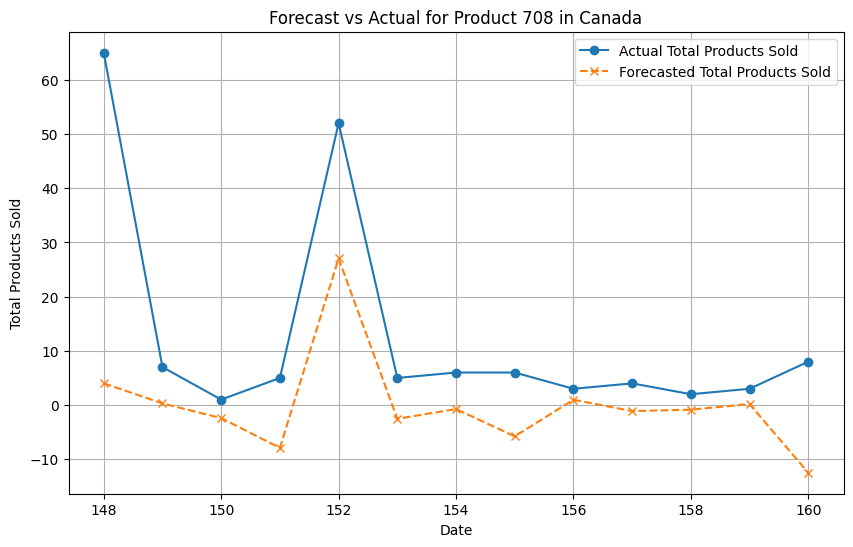

In [38]:
import matplotlib.pyplot as plt

# Function to plot actual vs forecasted sales
def plot_forecast(actual, forecast, product_id, territory):
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual.values, label='Actual Total Products Sold', marker='o')
    plt.plot(forecast.index, forecast.values, label='Forecasted Total Products Sold', linestyle='--', marker='x')
    plt.title(f'Forecast vs Actual for Product {product_id} in {territory}')
    plt.xlabel('Date')
    plt.ylabel('Total Products Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

# Select a specific product and territory to visualize 
product_id = 708  
territory = 'Canada'  # Replace with actual territory name

# Get the actual and forecasted sales for the selected product and territory
actual_sales = weekly_sales_df[
    (weekly_sales_df['product_id'] == product_id) & 
    (weekly_sales_df['sales_territory_name'] == territory)
]['total_products_sold'][-len(sarima_forecasts[sarima_forecasts['product_id'] == product_id]['original_forecast'].values[0]):]

forecasted_sales = pd.Series(
    sarima_forecasts[sarima_forecasts['product_id'] == product_id]['original_forecast'].values[0],
    index=actual_sales.index
)

# Plot the actual vs forecasted values
plot_forecast(actual_sales, forecasted_sales, product_id, territory)


## Seasonality analysis
- Here we do a seasonality analysis to understand if there is seasonality trends in sales data
- The selected product is 707 in Southwest, since it has the most weeks of sales different than 0

In [39]:
# Get product-territory combinations with more than 80 weeks of data
most_weeks_combinations = time_series_df[time_series_df['total_products_sold'] > 0] \
    .groupby(['product_id', 'sales_territory_name'])['week_start_date'] \
    .nunique() \
    .loc[lambda x: x > 80] \
    .index

most_weeks_combinations


MultiIndex([(708, 'Southwest'),
            (711, 'Northwest'),
            (711, 'Southwest'),
            (712,    'Canada'),
            (712, 'Northwest'),
            (712, 'Southwest')],
           names=['product_id', 'sales_territory_name'])

### Understanding how seasonal sales data is

The seasonal decomposition analysis of the sales data for **product 708** in the **Southwest** region gives us the following insights based on the four components:

1. **Observed Data (total_products_sold):**
   - The observed data represents the raw sales data over time. There are clear fluctuations in weekly sales, with certain weeks showing sharp spikes, indicating a non-constant sales pattern. Sales seem to peak intermittently, but there is no clear immediate pattern by looking at the raw data alone.

2. **Trend:**
   - The trend component reveals a general upward movement in the sales of the product over time. Starting from a lower sales base, the trend rises steadily, suggesting that this product gained popularity or experienced increased demand over time. After reaching a peak, however, the trend appears to slightly decline, indicating a possible decrease in momentum.

3. **Seasonal Component:**
   - The seasonal component shows periodic patterns repeating over the weeks. The peaks and troughs suggest that there are certain periods where sales are consistently high or low on a cyclical basis. The seasonality suggests regular intervals where sales peak, likely driven by market demand during specific times of the year or promotions.

4. **Residual (Noise):**
   - The residual component accounts for the random fluctuations in the data that cannot be explained by the trend or seasonality. In this case, the residuals appear to be centered around zero, indicating that most deviations from the trend and seasonality are relatively minor. However, there are a few outliers, as shown by the larger dots in the residual plot.

Key Takeaways:
- The upward **trend** indicates growing demand for product 708 over time in the Southwest, although it starts to plateau and decline slightly towards the end of the period.
- The **seasonality** suggests strong periodic sales behavior, likely tied to external factors such as holidays, marketing campaigns, or other cyclical events.
- While there are some **residual** fluctuations, they do not significantly impact the overall trend and seasonal pattern, meaning the data is relatively well-explained by these components.

In conclusion, the product shows strong seasonal tendencies, with a notable upward trend over the analyzed period, indicating the product is well-established but might face slight declines or saturation in sales.


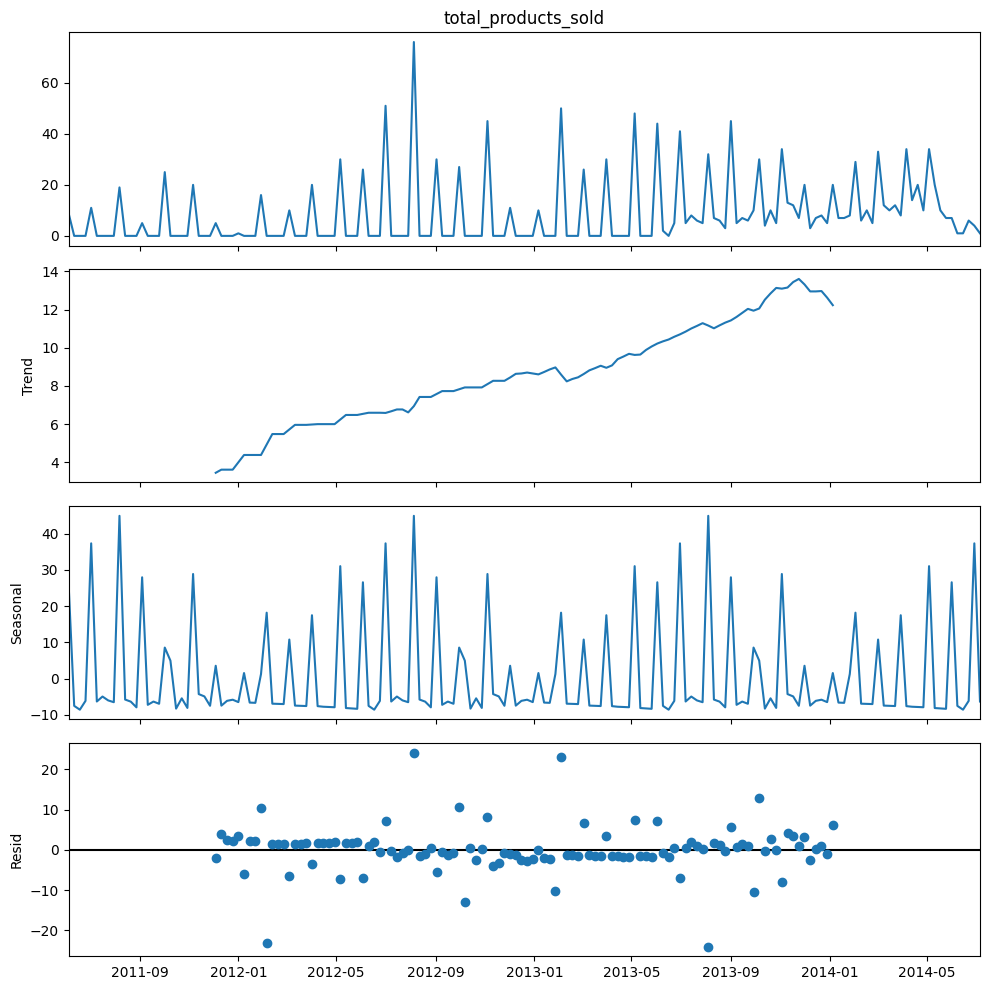

In [40]:
# Step 1: Filter the data for product_id 708 and sales_territory_name 'Southwest'
filtered_sales = weekly_sales_df[(weekly_sales_df['product_id'] == 708) & 
                                 (weekly_sales_df['sales_territory_name'] == 'Southwest')]

# Step 2: Convert 'week_start_date' to datetime if it is not already
filtered_sales['week_start_date'] = pd.to_datetime(filtered_sales['week_start_date'])

# Step 3: Set 'week_start_date' as the index for time series analysis
filtered_sales.set_index('week_start_date', inplace=True)


# Step 5: Decompose the time series to analyze the trend, seasonality, and noise
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition using an additive model (can also use multiplicative)
decomposition = seasonal_decompose(filtered_sales['total_products_sold'], model='additive', period=52)

# Step 6: Plot the decomposition
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (10,10)})
decomposition.plot()
plt.show()


### Understanding how lagged sales data is important for future predictions

The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots provide critical insights into how past weeks' sales (lagged data) impact future sales. These insights are essential for building predictive models, such as ARIMA or SARIMA models, to forecast future sales based on historical data. 

#### Autocorrelation Function (ACF):
- The ACF plot shows how the sales data is correlated with itself over various lag periods. 
- We observe a strong positive correlation at lag 1, indicating that the sales in the current week are highly influenced by sales in the previous week. This suggests a persistent short-term relationship.
- At higher lags, the correlation decreases but remains above the significance threshold for some points, like lag 4, lag 8, and lag 12. This hints at the presence of cyclical or seasonal patterns, where sales might exhibit repeating patterns every few weeks.
- The gradual decline in autocorrelation after the first few lags suggests that while past sales affect future sales, their influence weakens as the lag increases.

#### Partial Autocorrelation Function (PACF):
- The PACF plot helps in identifying the direct relationship between sales at different lagged intervals, controlling for the effect of intermediate lags.
- In this case, the PACF plot shows a significant correlation at lag 1, confirming that last week's sales are the most influential factor for this week’s sales. Beyond lag 1, the significant values diminish quickly.
- The PACF plot drops to near zero after lag 1, indicating that most of the predictive power lies in the first lag, and higher-order lags do not contribute as much after accounting for the direct effect of lag 1.

#### Key Insights:
- **Short-term dependence**: There is a strong correlation between consecutive weeks (lag 1), meaning the recent week's sales heavily influence the following week's sales.
- **Seasonal/Cyclical behavior**: The spikes at regular intervals in the ACF plot suggest some form of cyclical behavior, which might be driven by recurring events or promotions.
- **Model Implication**: Given the significant autocorrelation at lag 1 and a rapid drop-off in subsequent lags, an AR(1) model might be sufficient to capture the relationship in sales data for short-term forecasting.

Overall, this analysis suggests that past sales data, particularly from the immediate preceding weeks, are crucial for predicting future sales, with some minor influence from farther-back weeks reflecting possible seasonal patterns.


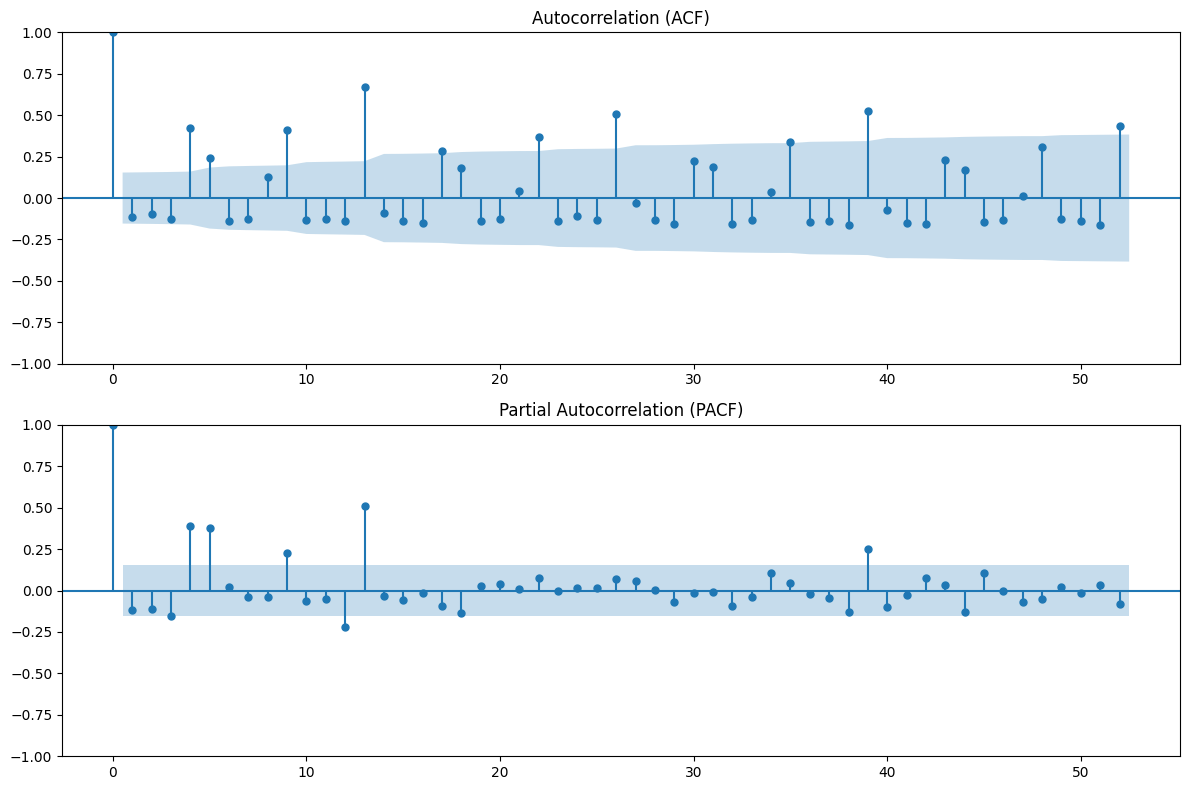

In [41]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Filter the data for product_id 708 and sales_territory_name 'Southwest'
filtered_sales = weekly_sales_df[(weekly_sales_df['product_id'] == 708) & 
                                 (weekly_sales_df['sales_territory_name'] == 'Southwest')]

# Step 2: Convert 'week_start_date' to datetime if not already
filtered_sales['week_start_date'] = pd.to_datetime(filtered_sales['week_start_date'])

# Step 3: Set 'week_start_date' as the index
filtered_sales.set_index('week_start_date', inplace=True)

# Step 4: Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(12, 8))

# Autocorrelation Plot (ACF)
plt.subplot(211)
plot_acf(filtered_sales['total_products_sold'], lags=52, ax=plt.gca())
plt.title('Autocorrelation (ACF)')

# Partial Autocorrelation Plot (PACF)
plt.subplot(212)
plot_pacf(filtered_sales['total_products_sold'], lags=52, ax=plt.gca())
plt.title('Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()


# Forecasting sales using ML prediction algorithms

## Creating lag features
-  Create lag features and other time-based features to prepare the data for machine learning models.

In [45]:
# Creating lag features for supervised learning
def create_lag_features(df, lags, rolling_window=3):
    df = df.copy()
    
    # Create lag features for total_products_sold
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df.groupby(['product_id', 'sales_territory_name'])['total_products_sold'].shift(lag)
    
    # Create rolling mean feature as additional information
    df['rolling_mean'] = df.groupby(['product_id', 'sales_territory_name'])['total_products_sold'].transform(lambda x: x.rolling(rolling_window).mean())
    
    # Create date-related features
    df['month'] = df['week_start_date'].dt.month
    df['week'] = df['week_start_date'].dt.isocalendar().week
    df['day_of_week'] = df['week_start_date'].dt.dayofweek
    
    # Drop rows with NaN values (from lag and rolling mean)
    df = df.dropna()
    
    return df

# Apply the function to create lag features
lags = 5  # Number of past weeks to use for prediction
weekly_sales_ml = weekly_sales_df.drop('differenced_sales', axis=1)
weekly_sales_ml = create_lag_features(weekly_sales_df, lags)
weekly_sales_ml.head()

,week_start_date,product_id,sales_territory_name,total_products_sold,differenced_sales,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,month,week,day_of_week
5,2011-07-10,708,Canada,0,-15,15,0,0,0,8,5.0,7,27,6
6,2011-07-17,708,Canada,0,0,0,15,0,0,0,5.0,7,28,6
7,2011-07-24,708,Canada,0,0,0,0,15,0,0,0.0,7,29,6
8,2011-07-31,708,Canada,0,0,0,0,0,15,0,0.0,7,30,6
9,2011-08-07,708,Canada,15,15,0,0,0,0,15,5.0,8,31,6


## Enconding categorical variables

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoding to categorical variables
def encode_categorical_features(df):
    # Columns to encode
    categorical_columns = ['product_id', 'sales_territory_name']
    
    # OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # Use sparse_output instead of sparse
    encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
    
    # Drop original categorical columns and concatenate the encoded columns
    df = df.drop(categorical_columns, axis=1)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Apply the function to your dataset
weekly_sales_ml_encoded = encode_categorical_features(weekly_sales_ml)

# Check the transformed data
weekly_sales_ml_encoded.head()


,week_start_date,total_products_sold,differenced_sales,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean,month,...,product_id_711,product_id_712,product_id_715,sales_territory_name_Central,sales_territory_name_France,sales_territory_name_Northeast,sales_territory_name_Northwest,sales_territory_name_Southeast,sales_territory_name_Southwest,sales_territory_name_United Kingdom
5,2011-07-10,0,-15,15,0,0,0,8,5.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2011-07-17,0,0,0,15,0,0,0,5.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2011-07-24,0,0,0,0,15,0,0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2011-07-31,0,0,0,0,0,15,0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2011-08-07,15,15,0,0,0,0,15,5.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train-Test Split:
- Since this is a time series problem, we will split the dataset into training and test sets based on time (instead of random splitting).

In [59]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = weekly_sales_ml_encoded.drop(['total_products_sold', 'week_start_date'], axis=1)
y = weekly_sales_ml_encoded['total_products_sold']

# Also extract 'week_start_date' for splitting
week_start_date = weekly_sales_ml_encoded['week_start_date']

# Use train_test_split for splitting the dataset (including 'week_start_date')
X_train, X_test, y_train, y_test, week_start_train, week_start_test = train_test_split(
    X, y, week_start_date, test_size=0.2, random_state=42, shuffle=False
)

# Check the shape of the training and test sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"week_start_train shape: {week_start_train.shape}")
print(f"week_start_test shape: {week_start_test.shape}")


X_train shape: (3723, 20)
X_test shape: (931, 20)
y_train shape: (3723,)
y_test shape: (931,)
week_start_train shape: (3723,)
week_start_test shape: (931,)


## ML models training
- Training models after creating lag features and splitting in test and train datasets

In [60]:
# Ensure the feature set is in a float format that can handle NaN values and fractional numbers
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# Ensure the target variable is also converted to a float
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

# Option 1: Fill missing values with mean
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_test.mean())

# For the target variable, it's generally better to fill or drop NaN
y_train_filled = y_train.fillna(y_train.mean())
y_test_filled = y_test.fillna(y_test.mean())

# Proceed with model training and prediction
rf_model.fit(X_train_filled, y_train_filled)
xgb_model.fit(X_train_filled, y_train_filled)

rf_predictions = rf_model.predict(X_test_filled)
xgb_predictions = xgb_model.predict(X_test_filled)

# Evaluate the models
rf_mae = mean_absolute_error(y_test_filled, rf_predictions)
rf_rmse = mean_squared_error(y_test_filled, rf_predictions, squared=False)

xgb_mae = mean_absolute_error(y_test_filled, xgb_predictions)
xgb_rmse = mean_squared_error(y_test_filled, xgb_predictions, squared=False)

# Print results
print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}")
print(f"XGBoost - MAE: {xgb_mae}, RMSE: {xgb_rmse}")


Random Forest - MAE: 0.2137925077790205, RMSE: 0.5107389115533196
XGBoost - MAE: 0.33665097653765064, RMSE: 0.5963198964639486


# Sales Prediction Model Comparison: Random Forest, XGBoost, and Time Series

## Introduction

In this analysis, we compare the performance of two machine learning models, **Random Forest** and **XGBoost**, against a traditional **Time Series** model. The comparison is based on predicting the total products sold for **product_id = 708** in **Canada**.

## Model Performance Metrics

The performance of each model is evaluated using two common regression metrics:

- **MAE (Mean Absolute Error)**: Measures the average magnitude of errors in predictions.
- **RMSE (Root Mean Squared Error)**: Measures the square root of the average squared differences between actual and predicted values. RMSE is more sensitive to outliers than MAE.

### Random Forest Results:
- **MAE**: `0.2138`
- **RMSE**: `0.5107`

### XGBoost Results:
- **MAE**: `0.3367`
- **RMSE**: `0.5963`

### Time Series Results:
- **MAE**: `12.9462`
- **MSE**: `405.5374` (RMSE ≈ `20.13`)

## Key Comparisons

| Model            | MAE     | RMSE    |
|------------------|---------|---------|
| **Random Forest** | 0.2138  | 0.5107  |
| **XGBoost**       | 0.3367  | 0.5963  |
| **Time Series**   | 12.9462 | ~20.13  |

### Observations:

1. **Mean Absolute Error (MAE)**:
   - The **Random Forest** model has the lowest MAE at `0.2138`, followed by **XGBoost** with `0.3367`. In comparison, the **Time Series** model has a significantly higher MAE at `12.9462`.
   - This suggests that both Random Forest and XGBoost perform substantially better in terms of overall error reduction compared to the Time Series model.

2. **Root Mean Squared Error (RMSE)**:
   - The RMSE values for **Random Forest** (`0.5107`) and **XGBoost** (`0.5963`) are much lower than the Time Series model's RMSE (~`20.13`).
   - RMSE is particularly sensitive to large errors, so the lower RMSE values for the machine learning models indicate better handling of extreme values in the predictions.

## Conclusion

In this comparison:
- Both **Random Forest** and **XGBoost** outperform the **Time Series** model, exhibiting much lower MAE and RMSE values.
- The **Time Series** model shows significantly higher error rates, which suggests it may not be as well-suited for predicting sales in this context when compared to the machine learning approaches.
  
**Overall, Random Forest and XGBoost provide more accurate predictions for sales forecasting in this dataset, particularly for product 708 in the Canadian sales territory.**

## Recommendations

- **Consider using Random Forest** or **XGBoost** for future sales forecasting tasks, as they show significantly better performance over the traditional Time Series approach.
- Further hyperparameter tuning for machine learning models may lead to even better performance.

